In [1]:
from sklearn import datasets
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import StratifiedKFold
from statistics import mean


from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from os.path import isfile, join
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers.legacy import Adam

from keras.applications import VGG16
from keras.layers import GlobalMaxPooling2D, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [2]:
def loadModel(nameModel):
    json_file = open( nameModel + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    cnn = model_from_json(loaded_model_json)
    print(cnn)
    cnn.load_weights(nameModel + ".h5")
    print("Loaded model from disk")
    return cnn

In [3]:
def prediction(model, pathBatch, classValue, classes):
    class_test    = [f for f in listdir(pathBatch) if isfile(join(pathBatch, f))]
    roundedValues = np.zeros(len(class_test))
    realValues    = np.zeros(len(class_test))
    wrongPaths    = []
    wrongErrors   = []


    for i in range(len(class_test)):
        if not (".DS_Store" in class_test[i]):
            path = pathBatch + "/" + class_test[i]
            test_image = tf.keras.preprocessing.image.load_img(path, target_size=(64,64))
            test_image = tf.keras.preprocessing.image.img_to_array(test_image)
            test_image = np.expand_dims(test_image, axis=0)
            result     = model.predict(test_image/255.0, verbose=0)
            realValues[i]  = result
            if result[0][0] > 0.5:
                roundedValues[i] = 1
            else: 
                roundedValues[i] = 0
            error = abs(classes.get(classValue) - result)
            if(error > 0.25):
                wrongPaths.append(path)
                wrongErrors.append(error)

    
    if(classes.get(classValue)):
        accuracy = np.mean(roundedValues)
    else:
        accuracy = np.mean(np.where(roundedValues == 0, 1, 0))

    return accuracy, realValues, roundedValues, wrongPaths, wrongErrors

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30
    )

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '../dataset/test_set',
    target_size=(64,64),
    batch_size=32,
    class_mode='binary',)

Found 240 images belonging to 2 classes.


In [6]:
import pathlib 
import os


data_path = pathlib.Path(r'../dataset/training_set/')

img_path = list(data_path.glob('**/*.jpg')) + list(data_path.glob('**/*.jpeg')) + list(data_path.glob('**/*.JPG'))

print(len(img_path))

img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

print(len(img_labels))

3110
3110


In [7]:
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,PATH,LABELS
0,../dataset/training_set/machos/IMG_2447.JPG,machos
1,../dataset/training_set/hembras/IMG_20220830_1...,hembras
2,../dataset/training_set/machos/IMG_20220714_11...,machos
3,../dataset/training_set/hembras/IMG_20220714_1...,hembras
4,../dataset/training_set/machos/IMG_20220830_09...,machos


In [8]:
img_df['LABELS'].value_counts(ascending=True)

hembras    1552
machos     1558
Name: LABELS, dtype: int64

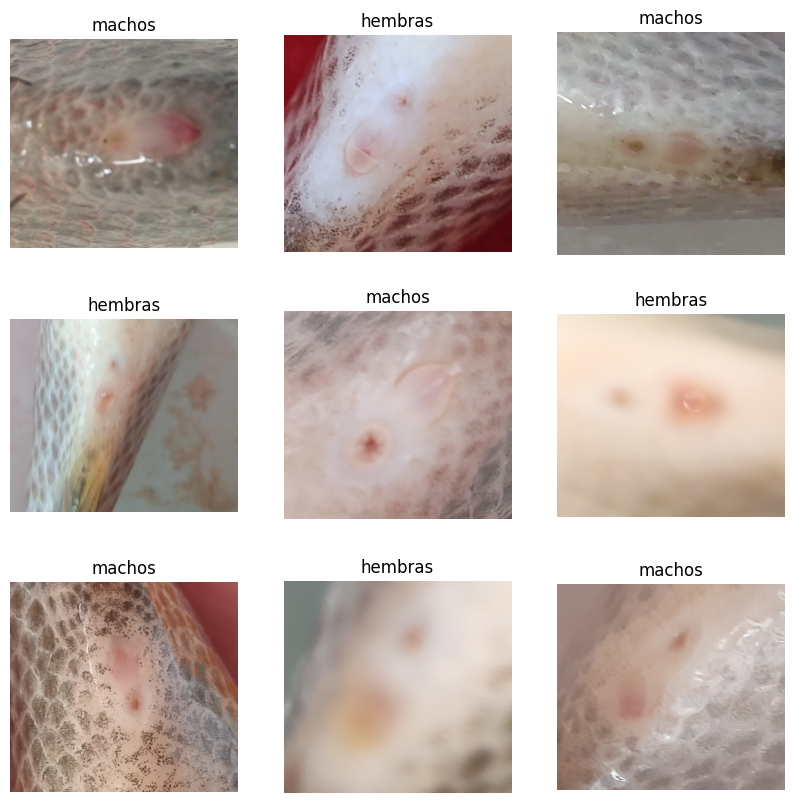

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img_df.PATH[i]))
  plt.title(img_df.LABELS[i])
  plt.axis("off")

In [10]:
def create_VGG16(): 
    pre_trained_model = VGG16(input_shape=[64, 64, 3], include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:15]:
        layer.trainable = False

    for layer in pre_trained_model.layers[15:]:
        layer.trainable = True

    last_layer = pre_trained_model.get_layer('block5_pool')
    last_output = last_layer.output

    x = GlobalMaxPooling2D()(last_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(pre_trained_model.input, x)

    adam = Adam(learning_rate=0.0005)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [11]:
from keras.callbacks import ModelCheckpoint

histories = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10) 

for f, (trn_ind, val_ind) in enumerate(kfold.split(img_df,img_labels)):
  print(); print("#"*50)
  print("Fold: ",f+1)
  print("#"*50)
  print(len(trn_ind))
  print(len(val_ind))
  train_ds = datagen.flow_from_dataframe(img_df.loc[trn_ind,:], 
  x_col='PATH', y_col='LABELS',
  target_size=(64, 64),
  batch_size=32,
  shuffle=True,
  class_mode='binary')
  val_ds = datagen.flow_from_dataframe(img_df.loc[val_ind,:], 
    x_col='PATH', y_col='LABELS',
    target_size=(64,64),
    batch_size=32,  
    shuffle=True,
    class_mode='binary')

  model = create_VGG16()

  # Guardar la arquitectura del modelo en formato JSON
  model_json = model.to_json()
  with open(str(f) + ".json", "w") as json_file:
    json_file.write(model_json)

  # Crear el callback para guardar el mejor modelo
  checkpoint = ModelCheckpoint(str(f) + "{val_accuracy:.2f}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  history = model.fit(x=train_ds, validation_data=val_ds, epochs=100, callbacks=[checkpoint])

  # store history for each folds
  histories.append(history)



##################################################
Fold:  1
##################################################
2799
311
Found 2799 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.
Epoch 1/100
88/88 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7506
Epoch 1: val_accuracy improved from -inf to 0.81350, saving model to 00.81.h5


/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 53s 529ms/step - loss: 0.4974 - accuracy: 0.7506 - val_loss: 0.3835 - val_accuracy: 0.8135
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8224
Epoch 2: val_accuracy improved from 0.81350 to 0.83601, saving model to 00.84.h5
88/88 [==============================] - 39s 447ms/step - loss: 0.3631 - accuracy: 0.8224 - val_loss: 0.3523 - val_accuracy: 0.8360
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8514
Epoch 3: val_accuracy improved from 0.83601 to 0.85531, saving model to 00.86.h5
88/88 [==============================] - 39s 447ms/step - loss: 0.3240 - accuracy: 0.8514 - val_loss: 0.3093 - val_accuracy: 0.8553
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8814
Epoch 4: val_accuracy did not improve from 0.85531
88/88 [==============================] - 39s 444ms/step - loss: 0.2683 - accuracy: 0.8814 - val_loss: 0.35

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 53s 531ms/step - loss: 0.4983 - accuracy: 0.7535 - val_loss: 0.3765 - val_accuracy: 0.8457
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.8278
Epoch 2: val_accuracy did not improve from 0.84566
88/88 [==============================] - 39s 445ms/step - loss: 0.3591 - accuracy: 0.8278 - val_loss: 0.3828 - val_accuracy: 0.8103
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8610
Epoch 3: val_accuracy did not improve from 0.84566
88/88 [==============================] - 40s 448ms/step - loss: 0.3294 - accuracy: 0.8610 - val_loss: 0.4824 - val_accuracy: 0.7588
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.8882
Epoch 4: val_accuracy improved from 0.84566 to 0.87460, saving model to 10.87.h5
88/88 [==============================] - 40s 447ms/step - loss: 0.2642 - accuracy: 0.8882 - val_loss: 0.2800 - val_accuracy: 0.8746
Epoc

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 54s 541ms/step - loss: 0.5478 - accuracy: 0.7181 - val_loss: 0.4062 - val_accuracy: 0.7942
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8264
Epoch 2: val_accuracy improved from 0.79421 to 0.84244, saving model to 20.84.h5
88/88 [==============================] - 41s 463ms/step - loss: 0.3790 - accuracy: 0.8264 - val_loss: 0.3541 - val_accuracy: 0.8424
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8646
Epoch 3: val_accuracy did not improve from 0.84244
88/88 [==============================] - 40s 456ms/step - loss: 0.3214 - accuracy: 0.8646 - val_loss: 0.3247 - val_accuracy: 0.8328
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8746
Epoch 4: val_accuracy improved from 0.84244 to 0.88103, saving model to 20.88.h5
88/88 [==============================] - 40s 455ms/step - loss: 0.2829 - accuracy: 0.8746 - val_loss: 0.27

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 54s 539ms/step - loss: 0.5010 - accuracy: 0.7546 - val_loss: 0.4769 - val_accuracy: 0.7588
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8432
Epoch 2: val_accuracy improved from 0.75884 to 0.86174, saving model to 30.86.h5
88/88 [==============================] - 40s 453ms/step - loss: 0.3525 - accuracy: 0.8432 - val_loss: 0.3297 - val_accuracy: 0.8617
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8532
Epoch 3: val_accuracy did not improve from 0.86174
88/88 [==============================] - 40s 452ms/step - loss: 0.3276 - accuracy: 0.8532 - val_loss: 0.3899 - val_accuracy: 0.8264
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.8817
Epoch 4: val_accuracy did not improve from 0.86174
88/88 [==============================] - 46s 528ms/step - loss: 0.2664 - accuracy: 0.8817 - val_loss: 0.3285 - val_accuracy: 0.8489
Epoc

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 56s 563ms/step - loss: 0.5201 - accuracy: 0.7367 - val_loss: 0.3766 - val_accuracy: 0.8264
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8192
Epoch 2: val_accuracy improved from 0.82637 to 0.83923, saving model to 40.84.h5
88/88 [==============================] - 42s 475ms/step - loss: 0.3869 - accuracy: 0.8192 - val_loss: 0.3653 - val_accuracy: 0.8392
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8432
Epoch 3: val_accuracy improved from 0.83923 to 0.88424, saving model to 40.88.h5
88/88 [==============================] - 42s 479ms/step - loss: 0.3455 - accuracy: 0.8432 - val_loss: 0.3005 - val_accuracy: 0.8842
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8735
Epoch 4: val_accuracy improved from 0.88424 to 0.89389, saving model to 40.89.h5
88/88 [==============================] - 44s 500ms/step - loss: 0.2930 - acc

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 55s 547ms/step - loss: 0.4992 - accuracy: 0.7535 - val_loss: 0.3567 - val_accuracy: 0.8296
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8446
Epoch 2: val_accuracy improved from 0.82958 to 0.89389, saving model to 50.89.h5
88/88 [==============================] - 40s 453ms/step - loss: 0.3589 - accuracy: 0.8446 - val_loss: 0.3009 - val_accuracy: 0.8939
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8703
Epoch 3: val_accuracy improved from 0.89389 to 0.92605, saving model to 50.93.h5
88/88 [==============================] - 40s 453ms/step - loss: 0.2921 - accuracy: 0.8703 - val_loss: 0.2140 - val_accuracy: 0.9260
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8650
Epoch 4: val_accuracy did not improve from 0.92605
88/88 [==============================] - 39s 449ms/step - loss: 0.2898 - accuracy: 0.8650 - val_loss: 0.24

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 54s 542ms/step - loss: 0.5027 - accuracy: 0.7460 - val_loss: 0.3407 - val_accuracy: 0.8521
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8485
Epoch 2: val_accuracy improved from 0.85209 to 0.88424, saving model to 60.88.h5
88/88 [==============================] - 41s 460ms/step - loss: 0.3523 - accuracy: 0.8485 - val_loss: 0.2883 - val_accuracy: 0.8842
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8457
Epoch 3: val_accuracy did not improve from 0.88424
88/88 [==============================] - 39s 448ms/step - loss: 0.3342 - accuracy: 0.8457 - val_loss: 0.2694 - val_accuracy: 0.8617
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8689
Epoch 4: val_accuracy did not improve from 0.88424
88/88 [==============================] - 39s 445ms/step - loss: 0.2942 - accuracy: 0.8689 - val_loss: 0.3023 - val_accuracy: 0.8778
Epoc

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 55s 553ms/step - loss: 0.5343 - accuracy: 0.7342 - val_loss: 0.4406 - val_accuracy: 0.7942
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8317
Epoch 2: val_accuracy improved from 0.79421 to 0.89389, saving model to 70.89.h5
88/88 [==============================] - 40s 451ms/step - loss: 0.3827 - accuracy: 0.8317 - val_loss: 0.2712 - val_accuracy: 0.8939
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8592
Epoch 3: val_accuracy did not improve from 0.89389
88/88 [==============================] - 39s 447ms/step - loss: 0.3198 - accuracy: 0.8592 - val_loss: 0.3076 - val_accuracy: 0.8746
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8696
Epoch 4: val_accuracy improved from 0.89389 to 0.90354, saving model to 70.90.h5
88/88 [==============================] - 40s 450ms/step - loss: 0.2915 - accuracy: 0.8696 - val_loss: 0.26

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 55s 548ms/step - loss: 0.5205 - accuracy: 0.7428 - val_loss: 0.3652 - val_accuracy: 0.8392
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8289
Epoch 2: val_accuracy improved from 0.83923 to 0.84566, saving model to 80.85.h5
88/88 [==============================] - 40s 451ms/step - loss: 0.3795 - accuracy: 0.8289 - val_loss: 0.3222 - val_accuracy: 0.8457
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8571
Epoch 3: val_accuracy improved from 0.84566 to 0.87781, saving model to 80.88.h5
88/88 [==============================] - 39s 446ms/step - loss: 0.3124 - accuracy: 0.8571 - val_loss: 0.2837 - val_accuracy: 0.8778
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8757
Epoch 4: val_accuracy improved from 0.87781 to 0.88746, saving model to 80.89.h5
88/88 [==============================] - 39s 447ms/step - loss: 0.2802 - acc

/Users/samuelguerrero/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 55s 545ms/step - loss: 0.5327 - accuracy: 0.7338 - val_loss: 0.3618 - val_accuracy: 0.8296
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8346
Epoch 2: val_accuracy improved from 0.82958 to 0.83923, saving model to 90.84.h5
88/88 [==============================] - 39s 448ms/step - loss: 0.3691 - accuracy: 0.8346 - val_loss: 0.2972 - val_accuracy: 0.8392
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8682
Epoch 3: val_accuracy did not improve from 0.83923
88/88 [==============================] - 39s 441ms/step - loss: 0.3114 - accuracy: 0.8682 - val_loss: 0.4181 - val_accuracy: 0.7942
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8725
Epoch 4: val_accuracy improved from 0.83923 to 0.89389, saving model to 90.89.h5
88/88 [==============================] - 39s 446ms/step - loss: 0.3013 - accuracy: 0.8725 - val_loss: 0.25

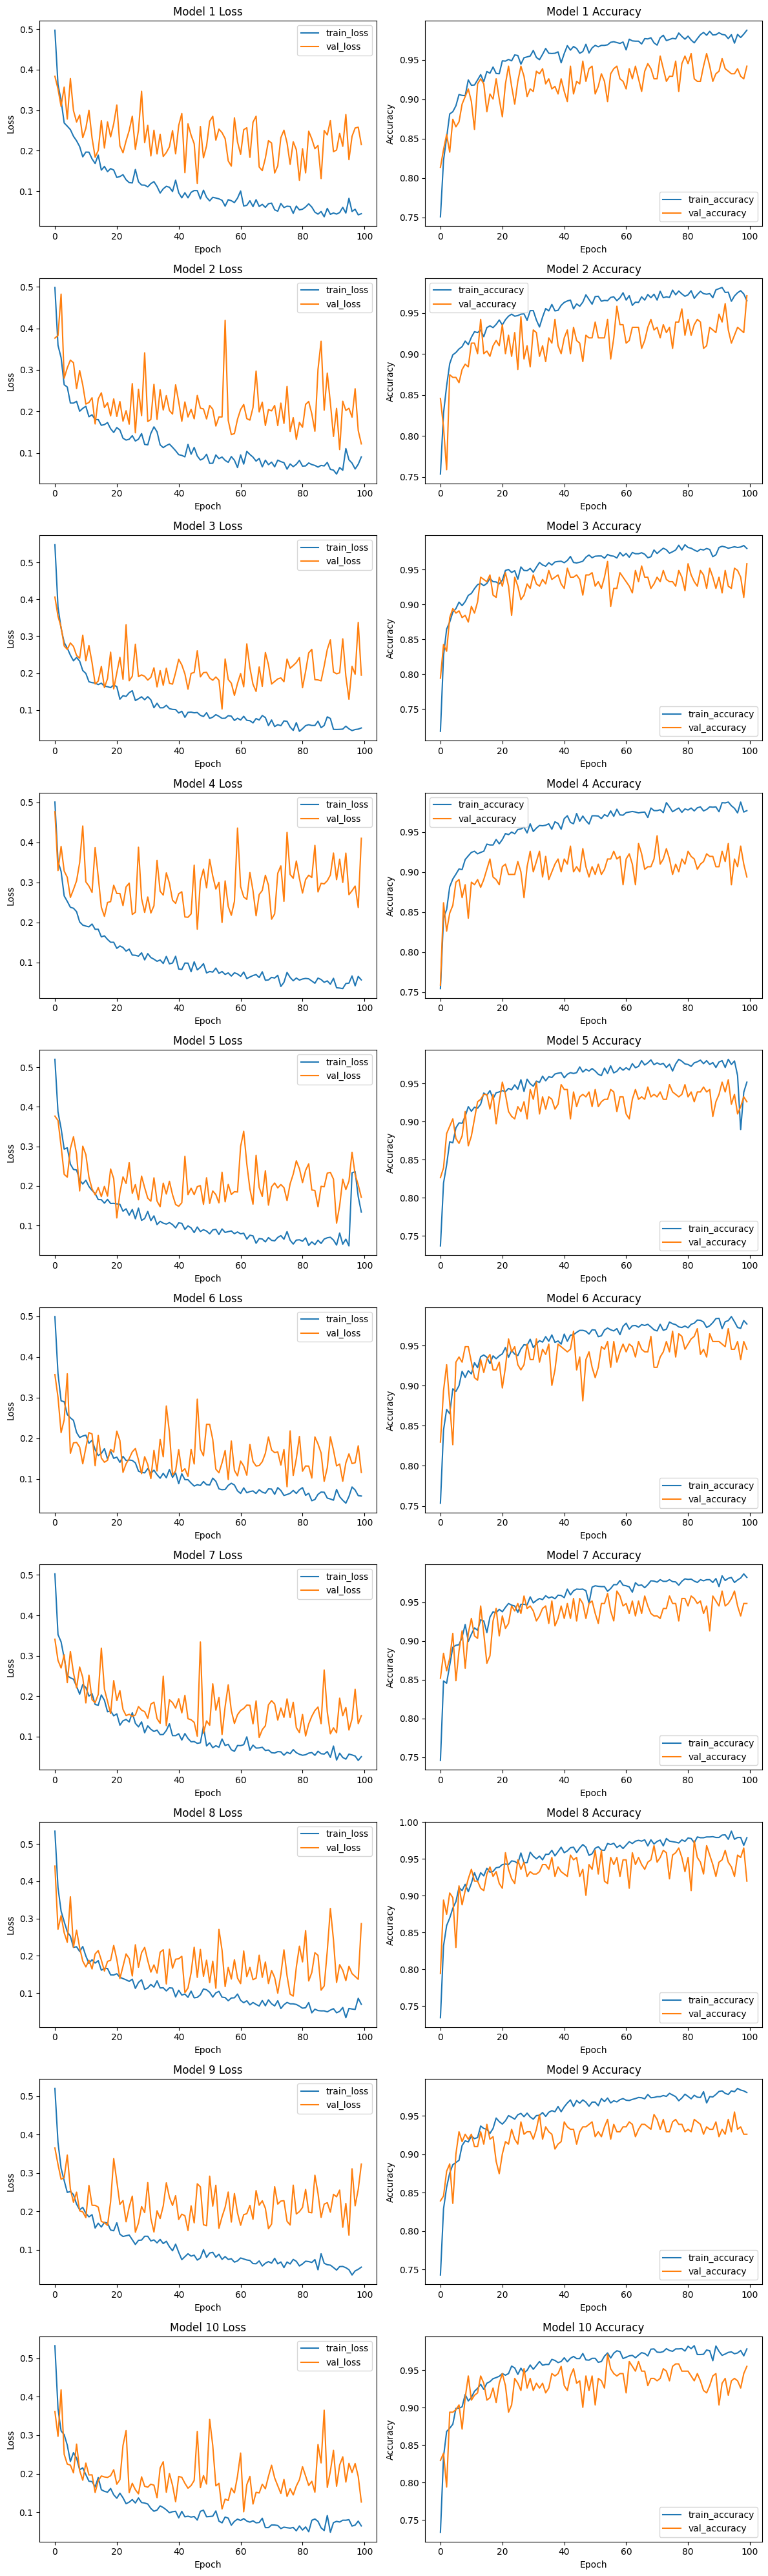

In [12]:
fig, axes = plt.subplots(nrows=len(histories), ncols=2, figsize=(12, len(histories) * 4))

# Iterar a través de las historias de los modelos
for i, history in enumerate(histories):
    # Subgráfica de precisión
    axes[i, 1].plot(history.history['accuracy'], label='train_accuracy')
    axes[i, 1].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[i, 1].set_title(f'Model {i + 1} Accuracy')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()


    # Subgráfica de pérdida
    axes[i, 0].plot(history.history['loss'], label='train_loss')
    axes[i, 0].plot(history.history['val_loss'], label='val_loss')
    axes[i, 0].set_title(f'Model {i + 1} Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

# Ajustar el diseño de las subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


In [13]:
#Print two classes.
print(list(test_set.class_indices.keys()))
classes = list(test_set.class_indices.keys())
hembras = classes[0]
machos = classes[1]

['hembras', 'machos']


In [14]:
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt  

def cargar_y_evaluar_modelos():
    archivos_h5 = [archivo.rstrip('.h5') for archivo in os.listdir() if archivo.endswith('.h5')]
    archivos_h5 = sorted(archivos_h5, key=lambda x: float(x.split('-')[0]))
    
    for i,modelo_archivo in enumerate(archivos_h5):
        print("Resultados del fold " + str(i+1))
        print(f"Modelo del archivo: {modelo_archivo}")
             
        modelo = loadModel(modelo_archivo)
        
        
        accuracyHembras, realValuesHembras, roundedValuesHembras, wrongPathsHembras, wrongErrorsHembras = prediction(model=modelo, pathBatch="../dataset/test_set/hembras", classValue=hembras, classes=test_set.class_indices)      
        accuracyMachos, realValuesMachos, roundedValuesMachos, wrongPathsMachos, wrongErrorsMachos = prediction(model=modelo, pathBatch="../dataset/test_set/machos", classValue=machos, classes=test_set.class_indices)
        
        print(f'Modelo con precisión en test con hembras: {accuracyHembras}')
        print(f'Modelo con precisión en test con machos: {accuracyMachos}')
        
        accuracy_general = (accuracyHembras + accuracyMachos) / 2
        print(f'Accuracy general del modelo: {accuracy_general}')
        
        pred = np.concatenate([roundedValuesHembras, roundedValuesMachos])
        result = confusion_matrix(test_set.classes, pred)
        
        sns.heatmap(result, annot=True, cmap='Blues', fmt='g')
        plt.show()  

        axisXHembras = np.linspace(0,(realValuesHembras.shape[0]-1),realValuesHembras.shape[0])
        axisXMachos  = np.linspace(0,(realValuesMachos.shape[0]-1),realValuesMachos.shape[0])

        plt.scatter(axisXHembras, realValuesHembras, c="#CD5C5C")
        plt.scatter(axisXMachos, realValuesMachos, c="#2E86C1")
        plt.axhline(y=0.5, color='green', linestyle='-')
        plt.show()
        
        print(classification_report(test_set.classes, pred))
        print("\n")

# Llamar a la función
cargar_y_evaluar_modelos()


Resultados del fold 1
Modelo del archivo: 00.81


FileNotFoundError: [Errno 2] No such file or directory: '00.81.json'

In [ ]:
ls

0-0.824999988079071.h5     6-0.925000011920929.h5
0-0.824999988079071.json   6-0.925000011920929.json
1-0.8666666746139526.h5    7-0.9333333373069763.h5
1-0.8666666746139526.json  7-0.9333333373069763.json
2-0.8583333492279053.h5    8-0.9375.h5
2-0.8583333492279053.json  8-0.9375.json
3-0.8833333253860474.h5    9-0.9166666865348816.h5
3-0.8833333253860474.json  9-0.9166666865348816.json
4-0.8999999761581421.h5    KFoldStratified.ipynb
4-0.8999999761581421.json  Models/
5-0.9166666865348816.h5    metricas_por_fold/
5-0.9166666865348816.json


In [ ]:
cnn94 = loadModel("0.824999988079071")

Sequential


AttributeError: 'str' object has no attribute 'load_weights'

In [ ]:
for f, (trn_ind, val_ind) in enumerate(kfold.split(img_df,img_labels)):
    print(); print("#"*50)
    print("Fold: ",f+1, " indices")
    print(trn_ind)
    print(val_ind)
    print("#"*50)



##################################################
Fold:  1  indices
[   0    1    2 ... 3107 3108 3109]
[  11   29   49   89  122  137  143  158  162  185  199  205  212  250
  260  285  287  316  329  332  355  360  368  374  392  408  411  420
  445  448  474  559  584  599  602  603  604  607  612  617  624  649
  652  661  662  670  675  695  707  712  718  764  770  784  789  818
  843  878  889  902  908  922  925  927  941  946  950  980  996 1007
 1015 1029 1036 1038 1042 1068 1080 1094 1109 1110 1114 1133 1146 1177
 1178 1181 1193 1230 1244 1250 1259 1261 1280 1290 1314 1326 1329 1331
 1342 1382 1383 1384 1413 1424 1428 1436 1466 1473 1501 1521 1550 1576
 1648 1654 1684 1688 1697 1716 1724 1729 1732 1736 1741 1776 1784 1786
 1794 1795 1799 1804 1818 1837 1840 1849 1865 1880 1882 1904 1910 1921
 1930 1958 1966 1997 2002 2046 2054 2065 2066 2076 2111 2136 2138 2149
 2153 2164 2187 2191 2197 2205 2218 2235 2257 2259 2267 2268 2272 2277
 2282 2285 2286 2328 2330 2336 2347 2386 2

In [ ]:
import csv

output_dir = 'metricas_por_fold/'

import os
os.makedirs(output_dir, exist_ok=True)

for fold, history in enumerate(histories):
    model_loss = history.history['loss']  
    val_loss = history.history['val_loss']  
    model_accuracy = history.history['accuracy']  
    val_accuracy = history.history['val_accuracy']  
    
    csv_filename = f'{output_dir}fold_{fold+1}_metrics.csv'
    
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_Accuracy', 'Val_Accuracy'])
        for epoch in range(len(model_loss)):
            writer.writerow([epoch+1, model_loss[epoch], val_loss[epoch], model_accuracy[epoch], val_accuracy[epoch]])

    print(f"Se ha guardado el archivo CSV para el fold {fold+1} en {csv_filename}")

Se ha guardado el archivo CSV para el fold 1 en metricas_por_fold/fold_1_metrics.csv
Se ha guardado el archivo CSV para el fold 2 en metricas_por_fold/fold_2_metrics.csv
Se ha guardado el archivo CSV para el fold 3 en metricas_por_fold/fold_3_metrics.csv
Se ha guardado el archivo CSV para el fold 4 en metricas_por_fold/fold_4_metrics.csv
Se ha guardado el archivo CSV para el fold 5 en metricas_por_fold/fold_5_metrics.csv
Se ha guardado el archivo CSV para el fold 6 en metricas_por_fold/fold_6_metrics.csv
Se ha guardado el archivo CSV para el fold 7 en metricas_por_fold/fold_7_metrics.csv
Se ha guardado el archivo CSV para el fold 8 en metricas_por_fold/fold_8_metrics.csv
Se ha guardado el archivo CSV para el fold 9 en metricas_por_fold/fold_9_metrics.csv
Se ha guardado el archivo CSV para el fold 10 en metricas_por_fold/fold_10_metrics.csv
